In [ ]:
%pip install xarray pathlib numpy matplotlib scipy

### Utility function

Run the cell below, but feel free to ignore this code — it’s some utility functions we’ll use later for convenience.

In [1]:
import matplotlib.pyplot as plt

def style_plot(title, xlabel, ylabel):
    '''
    Styles plots displaying filters. Adds labels, grids and shows legends

    Args:
        title: title of plot
        xlabel: label x-axis
        ylabel: label y-axis
    '''
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.legend();

class utils:
    style_plot = style_plot

## Download dataset

In [3]:
import owncloud
import os

if not os.path.exists('../../data'):
    print('Creating directory for data')
    os.mkdir('../data')

if not os.path.exists('../../data/dataset_session_754312389.nc'):
    print('Downloading data')
    owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/ZAs9uJ1KzrWi0ra').get_file('/', '../../data/dataset_session_754312389.nc')

### Load dataset

Run cells below to load dataset and extract relevant data

In [2]:
import xarray as xr
from pathlib import Path

In [3]:
loadpath = '../../data/dataset_session_754312389.nc'

dataset_path = Path(loadpath)

dataset = xr.load_dataset(dataset_path)
dataset

<xarray.Dataset> Size: 232MB
Dimensions:                             (channel_depth: 23,
                                         trial_stimulus_id: 75,
                                         time_from_stimulus_onset_lfp: 1875,
                                         time_from_stimulus_onset_csd: 1875,
                                         time_whole_rec: 373124,
                                         channel_depth_LM: 19,
                                         ...
                                         time_from_stimulus_onset_spikes: 1500,
                                         unit_id_V1: 91, unit_id_LM: 13,
                                         stimulus_start_times: 75,
                                         stimulus_stop_times: 75,
                                         channel_id: 23,
                                         time_from_stimulus_onset_lfp_trial: 1875)
Coordinates: (12/17)
  * channel_depth                       (channel_depth) int64 184B 0 ... -880
  * trial_stimulus_id                   (trial_stimulus_id) int32 300B 3649 ....
  * time_from_stimulus_onset_lfp        (time_from_stimulus_onset_lfp) float64 15kB ...
  * time_from_stimulus_onset_csd        (time_from_stimulus_onset_csd) float64 15kB ...
  * time_whole_rec                      (time_whole_rec) float64 3MB 1.286e+0...
  * channel_depth_LM                    (channel_depth_LM) int64 152B 0 ... -720
    ...                                  ...
  * unit_id_V1                          (unit_id_V1) int32 364B 951795075 ......
  * unit_id_LM                          (unit_id_LM) int32 52B 951791074 ... ...
  * stimulus_start_times                (stimulus_start_times) float64 600B 1...
  * stimulus_stop_times                 (stimulus_stop_times) float64 600B 1....
  * channel_id                          (channel_id) int32 92B 850144538 ... ...
  * time_from_stimulus_onset_lfp_trial  (time_from_stimulus_onset_lfp_trial) float64 15kB ...
Data variables:
    lfp_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_lfp) float64 26MB ...
    csd_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_csd) float64 26MB ...
    lfp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    ecp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    lfp_LM                              (channel_depth_LM, trial_stimulus_id_LM, time_from_stimulus_onset_LM_lfp) float64 11MB ...
    spike_counts_LGN                    (unit_id_LGN, trial_nr, time_from_stimulus_onset_spikes) int16 6MB ...
    spike_counts_V1                     (unit_id_V1, trial_nr, time_from_stimulus_onset_spikes) int16 20MB ...
    spike_counts_LM                     (unit_id_LM, trial_nr, time_from_stimulus_onset_spikes) int16 3MB ...
    pupil_width                         (trial_nr) float64 600B 39.12 ... 44.31
    run_speed                           (trial_nr) float64 600B 1.155 ... 1.711
Attributes:
    time_unit:                  millisecond
    lfp_unit:                   Volt
    channel_depth_unit:         micrometer
    note_channel_depth:         Measured in distance from electrode closest t...
    sampling_frequency_lfp:     1250
    sampling_frequency_spikes:  1000
    sampling_frequency_unit:    Hz

#### Extract extracellular potential (ECP) and LFP data

In [4]:
ecp_whole_rec = dataset['ecp_whole_recording']
time_ecp = ecp_whole_rec.time_whole_rec
time_lfp = time_ecp

sampling_frequency_lfp = dataset.sampling_frequency_lfp

# Introduction

In this notebook, you will apply filtering methods to real LFP data and combine the results of this filtering with other analyses.

- **Lowpass** filters - keep part of signal **below** a certain frequency.
- **Highpass** filters - keep part of signal **above** a certain frequency.
- **Bandpass** filters - keep part of signal **inside** a certain frequency range.
- **Bandstop** filters - keep part of signal **outside** a certain frequency range.

<br>
<img src="resources/filter_types_marked.png" alt="Filter types" width="40%" height="30%">


Credit: [allaboutcircuits.com](https://www.allaboutcircuits.com/technical-articles/low-pass-filter-tutorial-basics-passive-RC-filter/)

## Section 1

### Filter to obtain LFP from recorded extracellular potential

Lowpass filters are used to obtain LFP from the recorded extracellular potential but there's no universally agreed upon convention on which cutoff frequency to use. Most labs will use a cutoff frequency between 100 Hz and 500 Hz. If you use higher cutoff frequencies, you are more likely to include multi-unit activity (MUA) - that is, spikes - in your LFP. And spikes is noise if you want to study LFP alone. However, if you use a low cutoff frequency, you may lose important information in your LFP. Your choice of a cutoff frequency will ultimately depend on your analysis, but 300 Hz can be seen as a reasonable default value. It can also be a good idea to experiment with different cutoff values to see how that may affect your analysis.

| Code | Description |
| :-- | :-- |
| `b, a = signal.butter(filter_order, cutoff_frequency, btype = 'lowpass', fs = sampling_frequency)`| Create the coefficients `b` and `a` to be used in the lowpass filtering of the signal.|
| `w, h = signal.freqz(b, a, fs=sampling_frequency)`| Compute the frequency response of the filter with coefficients `b` and `a`. `h` is the frequency response (the filter's magnitude at a given frequency), `w` is the frequencies the response is calculated for.|
| `lfp_trace = signal.filtfilt(b, a, ecp_trace))`| Apply the constructed filter to the ``ecp`` trace from a single channel using the coefficients `b` and `a`.|
| `lfp = signal.filtfilt(b, a, ecp, axis = time_dim))`| Apply the constructed filter to an array containing the ``ecp`` recorded from all channels using the coefficients `b` and `a`. When the ecp data is multidimensional, the axis the filter is applied to needs to be specified to be along the time dimension of the data (default is ``axis = -1``).|
| `plt.plot(x, y)` | Plot y values against x values. |
| `plt.imshow(data, aspect = 'auto', cmap = 'selected_colormap')` | Plots a multidimensional array as an image. `aspect` sets the aspect ratio of the axis. `cmap` sets the colormap.|

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

**Example**: Construct and plot a lowpass butterworth filter with a cutoff frequency at 300 Hz. Apply it to the ECP trace from channel index 2 in the recording and plot both the original and the filtered trace together in a new plot. The filtered trace consitutes the LFP.

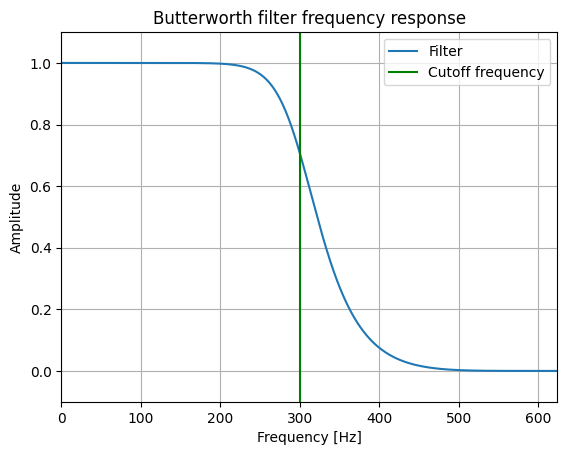

In [6]:
filter_order = 5 
cutoff_frequency = 300 # Hz

# creating butter filter
b, a = signal.butter(filter_order, cutoff_frequency, btype = 'low', fs = sampling_frequency_lfp)

w, h = signal.freqz(b, a, fs=sampling_frequency_lfp)

plt.plot(w, np.abs(h), label='Filter')

plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff_frequency, color='green', label='Cutoff frequency')
plt.legend();

(1405000.0, 1405200.0)

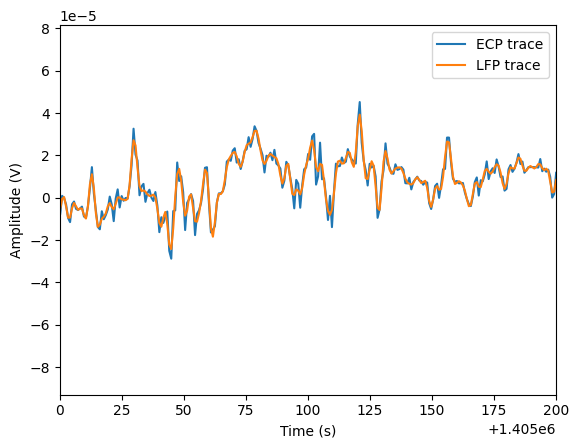

In [25]:
ichan = 2
ecp_single_chan = ecp_whole_rec[ichan]

filter_order = 5 #
cutoff_frequency = 300 # Hz

# creating butter filter
b, a = signal.butter(filter_order, cutoff_frequency, btype = 'lowpass', fs = sampling_frequency_lfp)

lfp_single_chan = signal.filtfilt(b, a, ecp_single_chan)

plt.plot(time_ecp, ecp_single_chan, label = 'ECP trace')
plt.plot(time_ecp, lfp_single_chan, label = 'LFP trace')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.xlim([1.405e6,1.4052e6])

**Exercise**: Construct and apply a lowpass butterworth filter (you don't have to plot it) with a cutoff frequency at 100 Hz to the ECP trace from channel index 2 in the recording. Plot the original and the filtered signals together.

(1405000.0, 1405200.0)

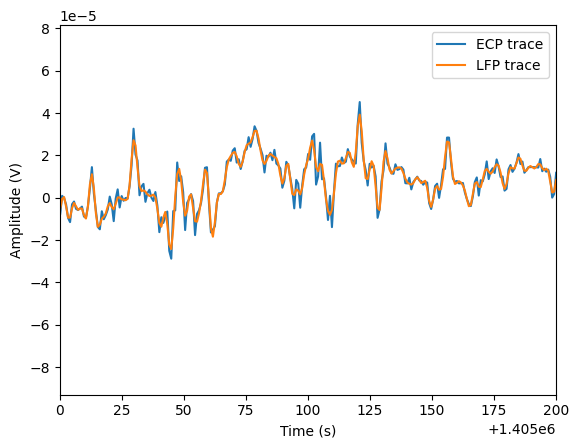

In [27]:
# Solution
filter_order = 5 
cutoff_frequency = 100 # Hz

# creating butter filter
b, a = signal.butter(filter_order, cutoff_frequency, btype = 'low', fs = sampling_frequency_lfp)

ichan = 2
ecp_single_chan = ecp_whole_rec[ichan]

filter_order = 5 #
cutoff_frequency = 300 # Hz

# creating butter filter
b, a = signal.butter(filter_order, cutoff_frequency, btype = 'lowpass', fs = sampling_frequency_lfp)

lfp_single_chan = signal.filtfilt(b, a, ecp_single_chan)

plt.plot(time_ecp, ecp_single_chan, label = 'ECP trace')
plt.plot(time_ecp, lfp_single_chan, label = 'LFP trace')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.xlim([1.405e6,1.4052e6])

**Exercise**: Construct and apply a butterworth filter with cutoff frequency 300 Hz to LFP from all channels. *Hint*: By specifying the axis in the data the filter is applied to in the `filtfilt` function, you don't need to select the trace from a single channel.

In [37]:
# Solution
filter_order = 5 
cutoff_frequency = 300 # Hz

# creating butter filter
b, a = signal.butter(filter_order, cutoff_frequency, btype = 'low', fs = sampling_frequency_lfp)


ecp_filt_low = signal.filtfilt(b, a, ecp_whole_rec, axis=1)

**Exercise**: Construct and apply a **highpass** butterworth filter with a cutoff frequency at 600 Hz to the ECP. Plot a single channel trace from the ECP to and the MUA (the highpass-filtered signal) together. 

This high-frequency part of the signal should mainly contain the multi-unit activity (MUA) - the spikes - in the extracellular potential. Is the amplitude of the resulting MUA signal, relative to the ECP, what you would expect when you compare it to the amplitude of the LFP above?

*Hint*: Change the `btype` parameter to create a highpass filter.

(1405000.0, 1405200.0)

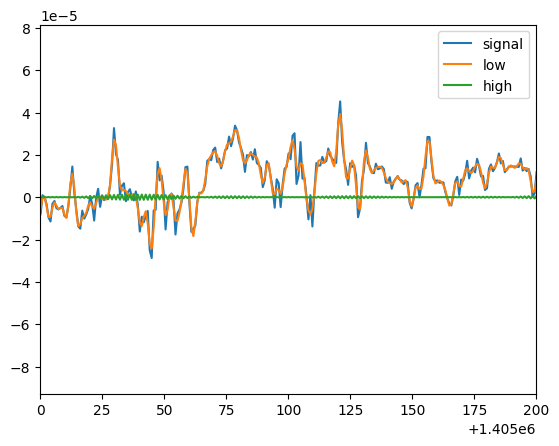

In [38]:
# Solution
filter_order = 5 
cutoff_frequency = 600 # Hz

# creating butter filter
b, a = signal.butter(filter_order, cutoff_frequency, btype = 'high', fs = sampling_frequency_lfp)


ecp_filt_high = signal.filtfilt(b, a, ecp_whole_rec, axis=1)

ichan=2
plt.plot(time_ecp, ecp_whole_rec[ichan],label='signal')
plt.plot(time_ecp, ecp_filt_low[ichan],label='low')
plt.plot(time_ecp, ecp_filt_high[ichan],label='high')
plt.legend()
plt.xlim([1.405e6,1.4052e6])

## Section 2

### Apply a bandpass filter to extract signal frequencies within specific range.

| Code | Description |
| :-- | :-- |
| `b, a = ss.butter(filter_order, [start_freq_band, end_freq_band], btype = 'bandpass', fs = sampling_frequency)`| Create the coefficients `b` and `a` to be used in the bandpass (or bandstop) filtering of the signal. To create a bandstop filter instead of a bandpass filter, simply set `btype = 'bandstop'`|
| `w, h = ss.freqz(b, a, fs=sampling_frequency)`| Compute the frequency response of the filter with coefficients `b` and `a`. `h` is the frequency response (the filter's magnitude at a given frequency), `w` is the frequencies at which the response is calculated.|
| `lfp_trace = ss.filtfilt(b, a, ecp_trace))`| Apply the constructed filter to the ecp signal at a specific channel using the coefficients `b` and `a`.|
| `plt.plot(x, y)` | Plot y values against x values. |
| `plt.imshow(data, aspect = 'auto', cmap = 'selected_colormap')` | Plots a multidimensional array as an image. `aspect` sets the aspect ratio of the axis. `cmap` sets the colormap.|

#### Load LFP from whole recording

In [34]:
lfp_whole_rec = dataset['lfp_whole_recording']
time_lfp = lfp_whole_rec.time_whole_rec
time_lfp = time_ecp

**Example**: Construct, plot, and apply a bandpass butterworth filter with a low cutoff at 250 Hz and a high cutoff at 500 Hz to the whole LFP data. Plot a single channel trace from the original and the filtered signal together in one plot.

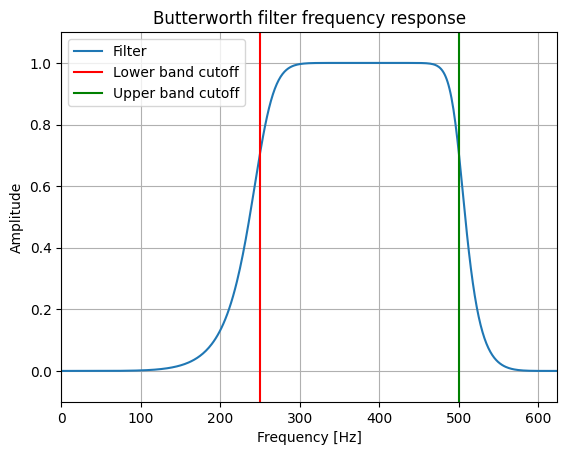

In [39]:
filter_order = 5 
sampling_frequency = 1250 # Hz
lowcut = 250 # Hz
highcut = 500 # Hz

# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'band', fs = sampling_frequency_lfp)

w, h = signal.freqz(b, a, fs=sampling_frequency) 

plt.plot(w, np.abs(h), label='Filter')
plt.axvline(lowcut, color='red', label='Lower band cutoff')
plt.axvline(highcut, color='green', label='Upper band cutoff')

utils.style_plot(title='Butterworth filter frequency response', xlabel = 'Frequency [Hz]', ylabel='Amplitude')

(1405000.0, 1405200.0)

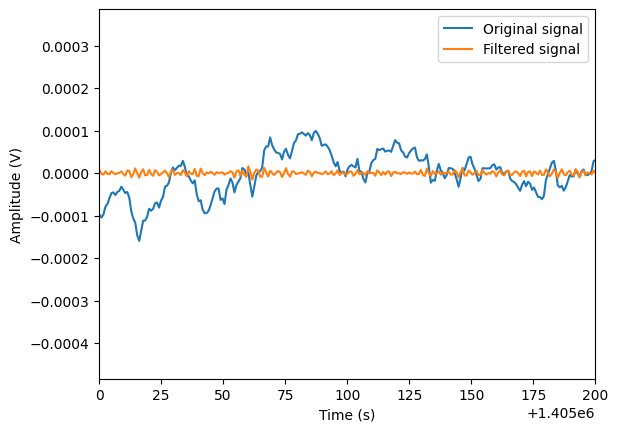

In [41]:
lfp_bandpass_filtered = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

ichan = 5
lfp_single_chan = lfp_whole_rec[ichan]
lfp_bandpass_single_chan = lfp_bandpass_filtered[ichan]
plt.plot(time_lfp, lfp_single_chan, label = 'Original signal')
plt.plot(time_lfp, lfp_bandpass_single_chan , label = 'Filtered signal')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.xlim([1.405e6,1.4052e6])

**Exercise**: Construct and apply a bandpass butterworth filter with a low cutoff at 50 Hz and a high cutoff at 70 Hz to the whole LFP data. Plot a single channel trace from the original and the filtered signal together in one plot.

Text(0, 0.5, 'Amplitude (V)')

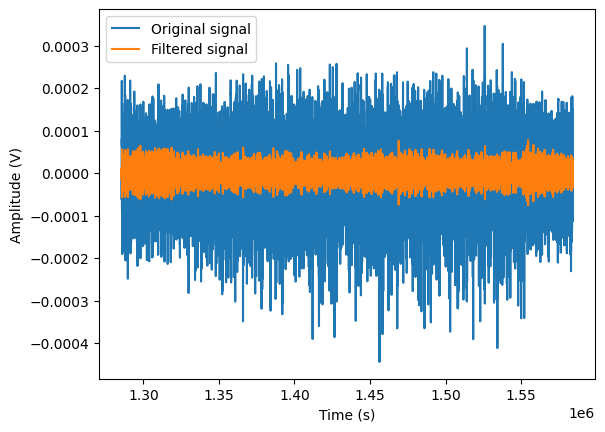

In [43]:
# solution
filter_order = 5 
sampling_frequency = 1250 # Hz
lowcut = 50 # Hz
highcut = 70 # Hz

# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'band', fs = sampling_frequency_lfp)

lfp_bandpass_filtered = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

ichan = 5
lfp_single_chan = lfp_whole_rec[ichan]
lfp_bandpass_single_chan = lfp_bandpass_filtered[ichan]
plt.plot(time_lfp, lfp_single_chan, label = 'Original signal')
plt.plot(time_lfp, lfp_bandpass_single_chan , label = 'Filtered signal')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
# plt.xlim([1.405e6,1.4052e6])

**Exercise**: Use the code below that gets the delta band LFP (1-4 Hz) to construct and apply filters to get the theta (4-8 Hz), alpha (8-13 Hz), beta (13-30 Hz), and gamma band (30-120 Hz) LFP.

In [56]:
# provided

filter_order = 2

''' Filter for delta band'''
lowcut = 1 # Hz
highcut = 4 # Hz
# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandpass', fs = sampling_frequency_lfp)
lfp_delta = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

In [57]:
# solution

''' Filter for theta band'''
lowcut = 4 # Hz
highcut = 8 # Hz
# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandpass', fs = sampling_frequency_lfp)
lfp_theta = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

''' Filter for alpha band'''
lowcut = 8 # Hz
highcut = 13 # Hz
# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandpass', fs = sampling_frequency_lfp)
lfp_alpha = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

''' Filter for beta band'''
lowcut = 13 # Hz
highcut = 30 # Hz
# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandpass', fs = sampling_frequency_lfp)
lfp_beta = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

''' Filter for gamma band'''
lowcut = 30 # Hz
highcut = 120 # Hz
# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandpass', fs = sampling_frequency_lfp)

lfp_gamma = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

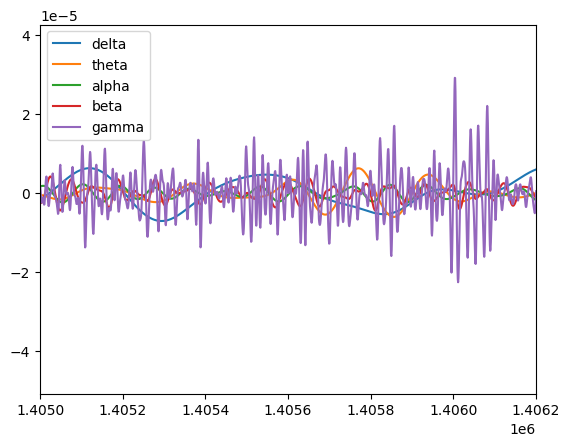

In [59]:
ichan=1
plt.plot(time_lfp, lfp_delta[ichan], label='delta')
plt.plot(time_lfp, lfp_theta[ichan], label='theta')
plt.plot(time_lfp, lfp_alpha[ichan], label='alpha')
plt.plot(time_lfp, lfp_beta[ichan], label='beta')
plt.plot(time_lfp, lfp_gamma[ichan], label='gamma')
plt.xlim([1.405e6,1.4062e6])
plt.legend()

## Section 3

### Relate frequencies to behavior

LFP oscillations in certain frequency bands have been shown to reflect both neural phenomena and behavior (and if they don't reflect a behavior or a neural phenomenon, they reflect an artifact of the experiment). In this section you'll see how filtering can be used to uncover associations between the power of an oscillation and behavioral data like running speed and pupil size.


| Code | Description |
| :-- | :-- |
| `b, a = signal.butter(filter_order, [start_freq_band, end_freq_band], btype = 'bandpass', fs = sampling_frequency)`| Create the coefficients `b` and `a` to be used in the lowpass filtering of the signal. |
| `lfp = signal.filtfilt(b, a, ecp, axis = time_dim))`| Apply the constructed filter to an array containing the ecp recorded from all channels using the coefficients `b` and `a`. When the ecp data is multidimensional, the axis at which the filter is applied needs to be specified to be along the time dimension of the data.|
| `plt.plot(x, y)` | Plot y values against x values. |
| `fig, ax = plt.subplots(nrows, ncols, figsize = (width, height))` | Make a 2x2 grid of subplots with 2 rows and 2 columns. `ax` can be indexed to refer to a specific subplot, f.ex. the subplot on the first row and second column would be `ax[0,1]`.|
| `ax_twin = ax1.twinx()` | Makes an extra axis in a subplot (the subplot of ``ax1``) such that data with different units can be plotted together in the same plot.|
| `np.mean(data, axis = (dim_num))` or `data.mean(axis = dim_num)` | Calculate the average of the data across the `dim_num` dimension of the array. |

#### Load behavioral data: Pupil width and running speed

In [54]:
# Extract pupil width
avg_pupil_width = dataset['pupil_width']

# Extract running speed
avg_run_speed = dataset['run_speed']

### Load LFP data organized by trials

In [55]:
# extract LFP trial data

lfp_trials = dataset['lfp_trials']

**Example**: Calculate the average[<sup>1</sup>](#fn1) absolute amplitude of the LFP in each trial. Plot the average LFP amplitude from channel index 5 together with the average running speed in each trial.

<span id="fn1"><sup>1</sup>
The average over the whole time period in a trial, not the trial average.
</span>

In [ ]:
# solution
lfp_avg_abs_amp = np.mean(np.abs(lfp_trials), axis = -1)
fig, ax = plt.subplots()

ax_run = ax
ax_run.plot(avg_run_speed, label = 'Running speed')

ax_lfp = ax.twinx()

ichan = 5
ax_lfp.plot(lfp_avg_abs_amp[ichan], color = 'g', label = 'LFP avg. absolute amplitude')

ax.set_xlabel('Trial #')
ax_run.set_ylabel('Running speed (a.u.)')
ax_lfp.set_ylabel('LFP (V)')

fig.legend();

(23, 75)

**Exercise**: Plot the average absolute amplitude of the LFP from channel index 5 together with the average pupil width in each trial.

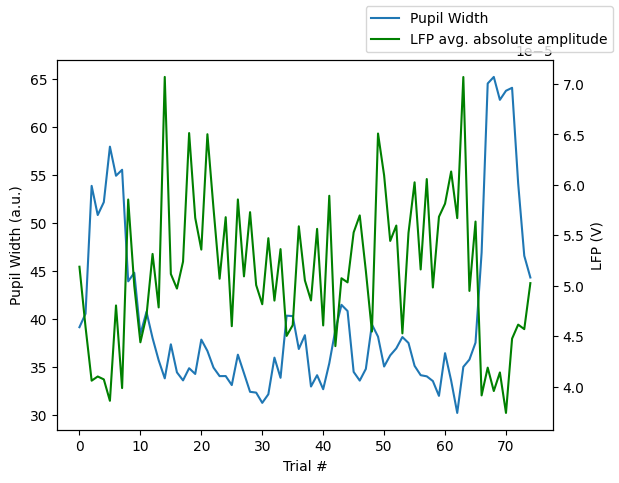

In [61]:
# solution
lfp_avg_abs_amp = np.mean(np.abs(lfp_trials), axis = -1)

fig, ax = plt.subplots()

ax_run = ax
ax_run.plot(avg_pupil_width, label = 'Pupil Width')

ax_lfp = ax.twinx()

ichan = 5
ax_lfp.plot(lfp_avg_abs_amp[ichan], color = 'g', label = 'LFP avg. absolute amplitude')

ax.set_xlabel('Trial #')
ax_run.set_ylabel('Pupil Width (a.u.)')
ax_lfp.set_ylabel('LFP (V)')

fig.legend();


**Exercise**: Construct and apply a bandpass filter with a low cutoff at 50 Hz and a high cutoff at 70 to get the **narrow** gamma range LFP.

In [69]:
# solution
filter_order = 2
lowcut = 50 # Hz
highcut = 70 # Hz
# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandpass', fs = sampling_frequency_lfp)

lfp_gamma_narrow = signal.filtfilt(b, a, lfp_trials, axis = -1)

**Exercise**: Plot the average amplitude of the filtered gamma range LFP together with the average pupil size in each trial.

Compare the overlap between pupil size and narrow gamma-band amplitude LFP in this plot to the overlap between pupil size and the total LFP amplitude in the exercise above. What do you notice?

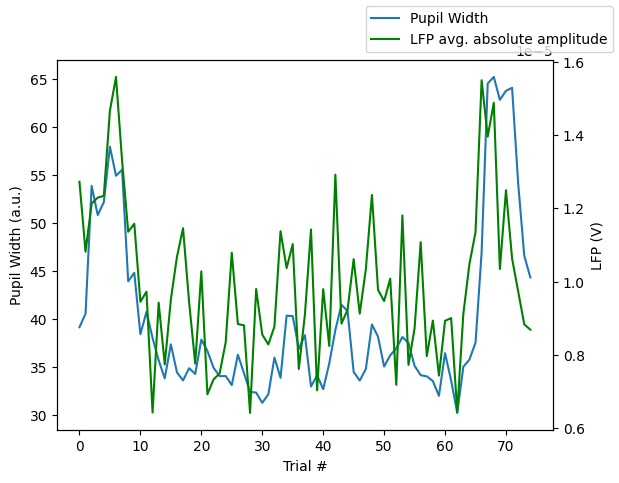

In [70]:
# solution
lfp_gamma_avg_abs_amp = np.mean(np.abs(lfp_gamma_narrow), axis = -1)

fig, ax = plt.subplots()

ax_run = ax
ax_run.plot(avg_pupil_width, label = 'Pupil Width')

ax_lfp = ax.twinx()

ichan = 5
ax_lfp.plot(lfp_gamma_avg_abs_amp[ichan], color = 'g', label = 'LFP avg. absolute amplitude')

ax.set_xlabel('Trial #')
ax_run.set_ylabel('Pupil Width (a.u.)')
ax_lfp.set_ylabel('LFP (V)')

fig.legend();

**Demo**: Run the cell below the average running speed together with the average pupil size in each trial.

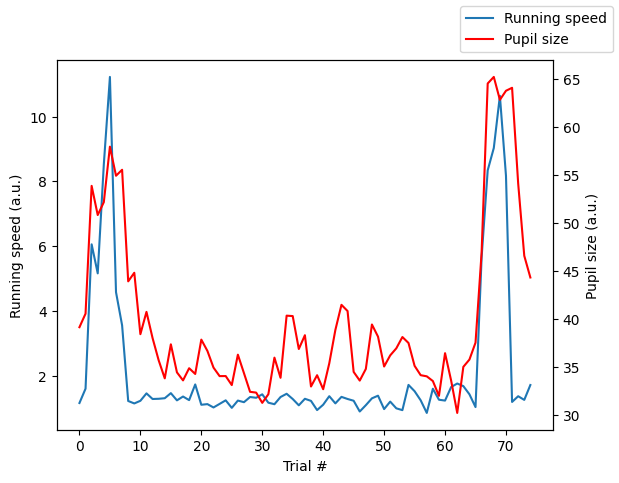

In [71]:
fig, ax = plt.subplots()

ax_run = ax
ax_run.plot(avg_run_speed, label = 'Running speed')

ax_pupil = ax.twinx()
ax_pupil.plot(avg_pupil_width, 'r', label = 'Pupil size')

ax.set_xlabel('Trial #')
ax_run.set_ylabel('Running speed (a.u.)')
ax_pupil.set_ylabel('Pupil size (a.u.)')

fig.legend()

## Section 4

### Apply bandstop (notch) filters to remove frequencies and to eliminate artifacts.

Overly consistent frequencies across a recording period - stripes across a whole spectrogram in all channels, for example - *may* indicate an artifact. In the figure below you can see an example of spectrograms computed for LFP that has such stripes. Those artifacts can be removed with a bandstop filter (also called a notch filter - a notch filter is simply a bandstop filter with a narrow range.)

<br>
<img src="resources/spectrogram-719161530-during-flashes.png" alt="Filter types" width="80%" height="30%">

| Code | Description |
| :-- | :-- |
| `b, a = signal.butter(filter_order, [start_freq_band, end_freq_band], btype = 'bandpass', fs = sampling_frequency)`| Create the coefficients `b` and `a` to be used in the lowpass filtering of the signal. |
| `w, h = signal.freqz(b, a, fs=sampling_frequency)`| Compute the frequency response of the filter with coefficients `b` and `a`. `h` is the frequency response (the filter's magnitude at a given frequency), `w` is the frequencies at which the response is calculated.|
| `lfp_trace = signal.filtfilt(b, a, ecp_trace))`| Apply the constructed filter to the ecp signal at a specific channel using the coefficients `b` and `a`.|
| `lfp_filtered = signal.filtfilt(b, a, lfp, axis = time_dim))`| Apply the constructed filter to an array containing the LFP recorded from all channels using the coefficients `b` and `a`. When the LFP data is multidimensional, the axis the filter is applied to needs to be specified to be along the time dimension of the data.|
| `plt.plot(x, y)` | Plot y values against x values. |

**Example**: Construct, plot, and apply a *bandstop* butterworth filter with a low cutoff at 50 Hz and a high cutoff at 60 Hz to the LFP from the whole recording.

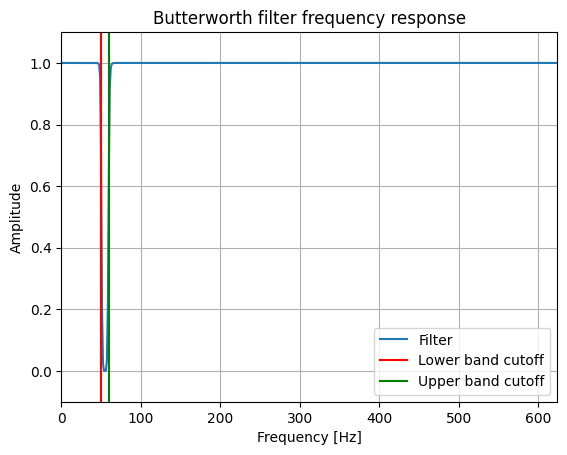

In [73]:
filter_order = 5
lowcut = 50 # Hz
highcut = 60 # Hz

# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandstop', fs = sampling_frequency_lfp)

w, h = signal.freqz(b, a, fs=sampling_frequency_lfp) # freqz because digital filter

plt.plot(w, np.abs(h), label='Filter')

plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(lowcut, color='red', label='Lower band cutoff') # cutoff frequency
plt.axvline(highcut, color='green', label='Upper band cutoff') # cutoff frequency
plt.legend();

Text(0.5, 0, 'Time (s)')

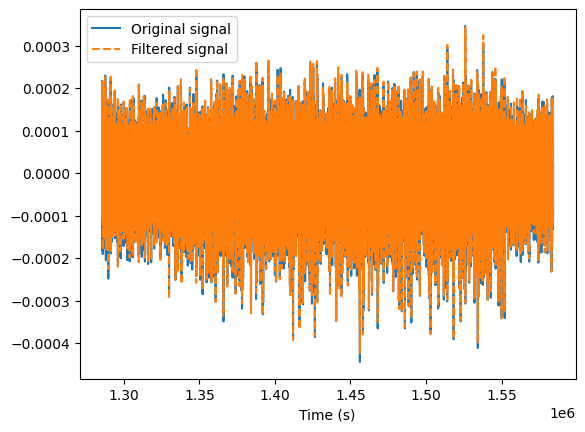

In [74]:
lfp_bandstopped = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

ichan = 5
lfp_single_chan = lfp_whole_rec[ichan]
bandstopped_lfp_single_chan = lfp_bandstopped[ichan]
plt.plot(time_lfp, lfp_single_chan, label = 'Original signal')
plt.plot(time_lfp, bandstopped_lfp_single_chan, label = 'Filtered signal', ls = '--')
plt.legend()
plt.xlabel('Time (s)')

**Exercise**: Construct and apply a bandstop butterworth filter with a low cutoff at 300 Hz and a high cutoff at 350 Hz to the LFP from the whole recording. Plot a single channel trace from the original LFP and the bandstop filtered LFP together.

Text(0.5, 0, 'Time (s)')

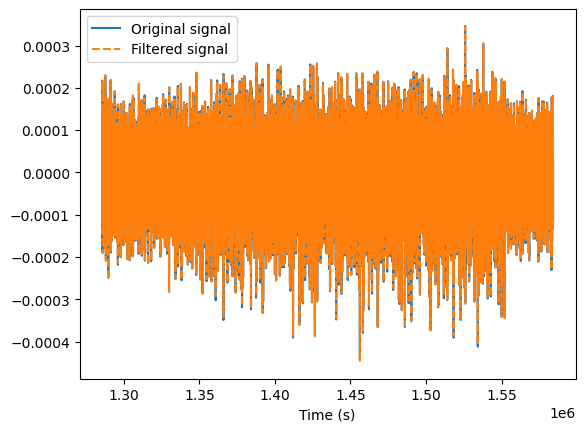

In [75]:
# solution
filter_order = 5
lowcut = 300 # Hz
highcut = 350 # Hz

# creating butter filter
b, a = signal.butter(filter_order, [lowcut, highcut], btype = 'bandstop', fs = sampling_frequency_lfp)

lfp_bandstopped = signal.filtfilt(b, a, lfp_whole_rec, axis = -1)

ichan = 5
lfp_single_chan = lfp_whole_rec[ichan]
bandstopped_lfp_single_chan = lfp_bandstopped[ichan]
plt.plot(time_lfp, lfp_single_chan, label = 'Original signal')
plt.plot(time_lfp, bandstopped_lfp_single_chan, label = 'Filtered signal', ls = '--')
plt.legend()
plt.xlabel('Time (s)')

**Exercise**: In the figure provided in the introduction to this section, there's a highly consistent and prominent horizontal stripe in the frequency spectrum at a little below 400 Hz in all channels. This is a candidate for an artifact. Remove this (potential) artifact from the LFP using a *bandstop* filter.